![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Text Mining: Models and Algorithms

## Problem Set 1

### *5. Write down three equations. One with just a "treatment period" dummy, one with just a "treatment city" dummy and then one that adds both of them with their interaction. This last regression gives you a difference-in-difference estimate of the effect of the event on prices. Explain which coefficient captures this treatment effect and why you need a second city for this. (3 points)*

#### **First regression**


Treatment_city is a dummy that takes 1 if the city belongs to Barcelona and 0 if the city is Valencia


        price= β₀ + β₁ Treatment_city + ϵ

#### **Second regression**


Treatment_period is a dummy that takes 1 if the days are between 13-15 june 2024 and 0 if the days are between 06-08 june 2024


        price= β₀ + β₁ Treatment_period + ϵ


#### **Third regression**

        price= β₀ + β1 ⋅Treatment_period + β2 ⋅Treatment_city+ β3 ⋅(Treatment_period×Treatment_city)+ϵ

The coefficient β3 represents the difference-in-differences (DiD) estimate.It captures the net effect of the event on prices by considering the interaction between "Treatment_period" and "Treatment_city.", therefore this term allow us to isolate and quantify the unique effect of the treatment when both factors are present.The need for a second city (control city) is crucial in DiD analysis to create a counterfactual. The control city allows us to account for trends or factors affecting both the treatment and control groups similarly that remain constant over time. The interaction term (Treatment_period × Treatment_city) captures the differential effect by considering how the treatment effect varies across the treatment and control groups.Therefore the DiD identify the treatment effect by contrasting the changes in the treatment city with the changes in the control city over the same period to avoid confunding variables and be more robust the estimation of the event's impact on prices.

### Import Functions


In [542]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mathieu26/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathieu26/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mathieu26/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [543]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import os
import seaborn as sns
import statsmodels.api as sm

# ML Functions
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

# NLP functions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob


import spacy
sp = spacy.load('en_core_web_sm')

import re
from nltk.corpus import stopwords

import warnings
# Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

# Setting the BSE color
color = (57/255, 129/255, 153/255)

### Create DataFrames

In [544]:
barcelona_p1 = pd.DataFrame(pd.read_csv('Barcelona-stars-06-08.csv'))
barcelona_p2 = pd.DataFrame(pd.read_csv('Barcelona-stars-13-15.csv'))
control_p1 = pd.DataFrame(pd.read_csv('Valencia-stars-06-08.csv'))
control_p2 = pd.DataFrame(pd.read_csv('Valencia-stars-13-15.csv'))

### Dummy variables

In [545]:
barcelona_p1['Treatment_period'] = 0
barcelona_p2['Treatment_period'] = 1
control_p1['Treatment_period'] = 0
control_p2['Treatment_period'] = 1

barcelona_p1['Treatment_city'] = 1
barcelona_p2['Treatment_city'] = 1
control_p1['Treatment_city'] = 0
control_p2['Treatment_city'] = 0

### Concatenate the Dataframes

In [546]:
df = pd.concat([barcelona_p1, barcelona_p2, control_p1, control_p2])

### Exploratory Data Analysis

In [547]:
# Create a new column for combined treatment condition
df['Treatment_condition'] = df['Treatment_period'] * 2 + df['Treatment_city']
df['Price'] = pd.to_numeric(df['Price'].str.replace('€', '').str.replace('.', ''), errors='coerce')
mapping = {0: 'Control_city_p1', 1: 'Treatment_city_p1', 2:'Control_city_p2', 3:'Treatment_city_p2'}
df['Treatment_city_and_treatment'] = df['Treatment_condition'].map(mapping)
df = df.drop('Treatment_condition', axis = 1)

In [548]:
df.head()

,Unnamed: 0,Hotels,Ratings,Price,Link,Stars,Descriptions,Treatment_period,Treatment_city,Treatment_city_and_treatment
0,0,Room Mate Gerard,"8,8",578,https://www.booking.com/hotel/es/room-mate-ger...,4,El Room Mate Gerard en Barcelona ofrece alojam...,0,1,Treatment_city_p1
1,1,Hotel Arts Barcelona,"8,4",1236,https://www.booking.com/hotel/es/arts-barcelon...,5,Este hotel de diseño tiene vistas a la playa d...,0,1,Treatment_city_p1
2,2,Hostal Balmes Centro,"7,3",206,https://www.booking.com/hotel/es/hostal-centro...,2,El Hostal Balmes Centro ofrece recepción 24 ho...,0,1,Treatment_city_p1
3,3,Hostal la Palmera,"8,6",251,https://www.booking.com/hotel/es/hostal-la-pal...,2,"Este hostal, de ambiente tranquilo, está situa...",0,1,Treatment_city_p1
4,4,Ilunion Auditori,"8,2",335,https://www.booking.com/hotel/es/confortel-aud...,3,"El Ilunion Auditori, situado a 10 minutos a pi...",0,1,Treatment_city_p1


### Plotting Prices with the different Treatment conditions

- Treated city in treatment Period
- Control city in Treatment period
- Treated city in Control Period
- Control city in Control Period

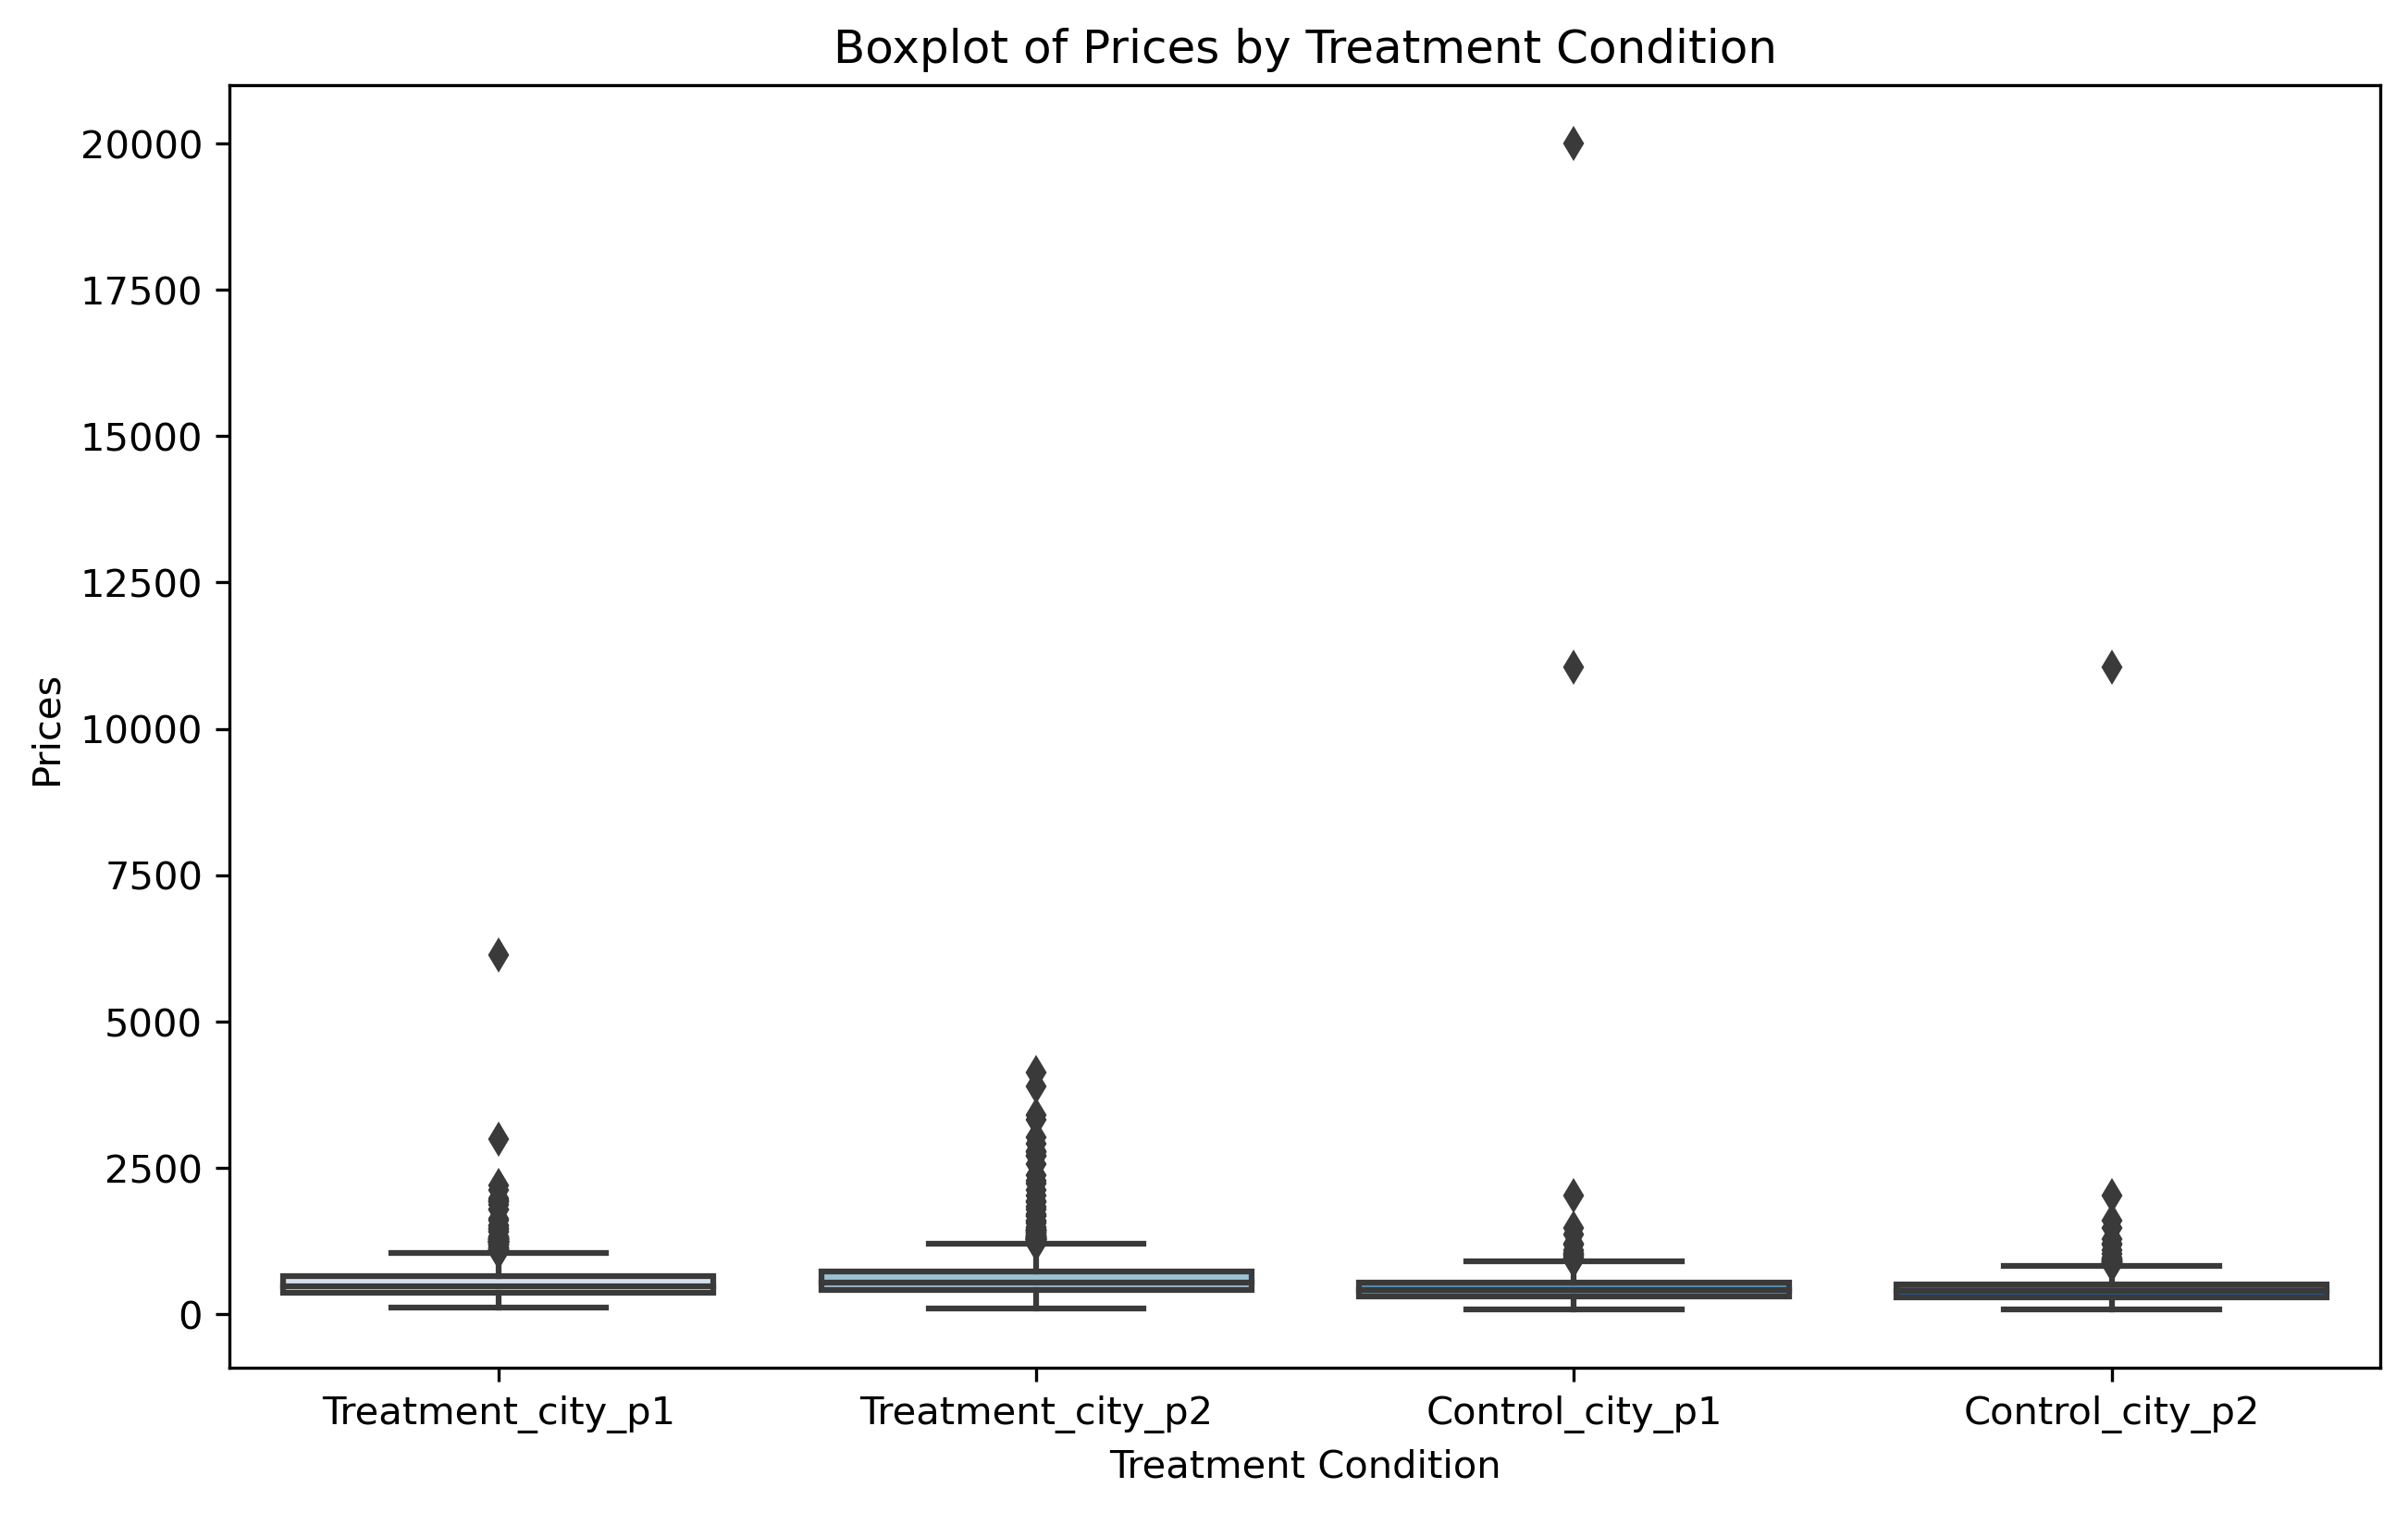

In [549]:
plt.figure(figsize=(10, 6), dpi=300)
sns.boxplot(data=df, x='Treatment_city_and_treatment', y='Price', palette='Blues')

plt.xlabel('Treatment Condition')
plt.ylabel('Prices')
plt.title('Boxplot of Prices by Treatment Condition')

plt.show()

The plot shows that there is a difference in the distribution of data as the observed prices for the treatment city have a greater standard deviation compared to the values in the control city. 

It also highlights a difference in the average price in the treatment city in the two different periods which is not matched in the control city, showing that there might be a positive effect of treatment on the prices.

### Average Prices

In [550]:
average_prices = df.groupby('Treatment_city_and_treatment')['Price'].mean()
average_prices

Treatment_city_and_treatment
Control_city_p1      485.670103
Control_city_p2      432.507645
Treatment_city_p1    551.051948
Treatment_city_p2    641.005931
Name: Price, dtype: float64

### *6. Estimate all three regressions. Make a standard regression table with 4 columns (3 for your answer here and one more below). Make sure you check how these regressions look like usually. Always report all coecients. Then carefully interpret them for each regression and the changes you see. (4 points)*

#### **Regression 1 (based on city)**

In [551]:
# Regression with only "treatment period" dummy
X1 = sm.add_constant(df['Treatment_city'])
model1 = sm.OLS(df['Price'], X1)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     44.13
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           3.62e-11
Time:                        19:57:08   Log-Likelihood:                -23811.
No. Observations:                3080   AIC:                         4.763e+04
Df Residuals:                    3078   BIC:                         4.764e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            457.5405     15.682     29.

#### Interpretation of regression 1

The first regression provides with the average difference in hotel price between Barcelona and Valencia during the period starting from the 13th to the 15th of June 2024. The average difference in hotel price between the 2 cities is 147.5 euros and is significant. This indicates that on average, during that period, average prices in hotels will be 147.5 euros higher in Barcelona than in Valencia. However, it is important to mention that this first regression does not control for other potential confounding factors. Hence, the difference may not necessary originate from the event happening in that period.

#### **Regression 2 (based on treatment period**)

In [552]:
# Regression with only "treatment period" dummy
X2 = sm.add_constant(df['Treatment_period'])
model2 = sm.OLS(df['Price'], X2)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.310
Date:                Sat, 03 Feb 2024   Prob (F-statistic):              0.253
Time:                        19:57:08   Log-Likelihood:                -23833.
No. Observations:                3080   AIC:                         4.767e+04
Df Residuals:                    3078   BIC:                         4.768e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              527.0139     13.953  

#### Interpretation of regression 2

The second regression indicates the average difference in hotel price between the period starting from the 13th to the 15th of June 2024 and the previous period starting from the 6th to the 8th of June 2024. The average difference in hotel price between the 2 periods is 26.7 euros and is significant. In other words, hotel prices during the period going from the 13th to the 15th appear to be higher in both cities in comparison to the previous period. 

#### **Regression 3 (Based on city and Treatment Period)**

In [553]:
# Regression with both "treatment period" and "treatment city" dummies and their interaction
df['Interaction_term'] = df['Treatment_period'] * df['Treatment_city']
X3 = sm.add_constant(df[['Treatment_period', 'Treatment_city', 'Interaction_term']])
model3 = sm.OLS(df['Price'], X3)
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     19.81
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           1.02e-12
Time:                        19:57:08   Log-Likelihood:                -23804.
No. Observations:                3080   AIC:                         4.762e+04
Df Residuals:                    3076   BIC:                         4.764e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              485.6701     22.804  

#### Interpretation of regression 3

The results of the third regression shows a high, positive and significant coefficient for the interaction term. This indicates that there is a significant positive effect of treatment on prices. In other words, we can conclude that the Sonár festival happening in Barcelona during that period positively influences hotel prices.

### *7. For each of the hotel descriptions do the following:*
 *(a) Extract at least two text features that can be useful controls in the regression. Think about the methods covered in class to transform text into numeric features and explain your decision. Show summary statistics for your feature for the different cities and time periods. (10 points)*


### NLP - Analyzing Descriptions

### Utils

In [554]:
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

In [555]:
df.shape

(3080, 11)

In [556]:
df = df.dropna()

### NLP Preprocessing:
- Removing special characters and numbers.
- Converting words to lowercase.
- Removing stopwords.
- Applying stemming.

EXPLAIN WHY STEMMING

AND 


WHICH FEATURES AND WHY
 - CORRELATION MATRIX
 - JUSTIFY WITH COMMON SENSE ON THE WORDS
 - FREQUENCE OF THE WORDS CHOSEN

In [557]:
text_column = 'Descriptions'

# Remove special characters and numbers
# df['processed_text'] = df[text_column].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# OR (if you want to keep numbers)
df['processed_text'] = df[text_column].apply(lambda x: re.sub(r'\W', ' ', x))

# Convert each word using abbr_or_lower function
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(abbr_or_lower(word) for word in x.split()))

# Remove stopwords
stop_words = set(stopwords.words('spanish'))
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Apply stemming
stemmer = PorterStemmer()
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

print(df['processed_text'])

0      room mate gerard barcelona ofrec alojamiento p...
1      hotel diseño vista playa barceloneta centro ba...
2      hostal balm centro ofrec recepción 24 hora ser...
3      hostal ambient tranquilo situado detrá mercado...
4      ilunion auditori situado 10 minuto pie estació...
                             ...                        
649    habitacion individu ofrec vista ciudad zona pl...
650    the river hostel situado centro valencia junto...
651    up hostel valencia valencia estación tren nort...
652    cantagua hostel bien situado barrio quatr carr...
653    livensa live studio valencia marina real 18 mi...
Name: processed_text, Length: 2902, dtype: object


### Creating a document-term matrix (DTM)

In [558]:
# Create document term matrix using CountVectorizer

pd.set_option('display.max_columns', None)
vectorizer = CountVectorizer(ngram_range = (1,2), min_df=0.05, max_df=0.30)
X = vectorizer.fit_transform(df['processed_text'])

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
display(dtm_df)
dtm_df.shape

,10,10 minuto,100,100 metro,11,11 km,12,12 km,13,13 km,14,14 km,15,15 minuto,16,17,19,20,20 minuto,200,200 metro,24,24 hora,300,300 metro,400,500,500 metro,abierta,acceso,acondicionado consta,acondicionado tv,acondicionado wifi,ademá,ademá cafetera,aeropuerto aeropuerto,aeropuerto barcelona,air libr,alberga,alojamiento air,alojamiento ofrec,alojamiento punto,alojamiento wifi,alquil,alrededor,amplia,aparcamiento,apart,apartamento air,apartamento cerca,apartamento km,apartamento ofrec,arena,art,art ciencia,art santuaria,artículo,artículo aseo,aseo,aseo gratuito,autobú,azotea,balcón,bar,barcelona ofrec,barcelona prat,barceloneta,bare,bare restaurant,barrio,barrio gótico,basílica,basílica virgen,batlló,bañera,baño compartido,baño ducha,bicicleta,bidet,bien,bioparc,bioparc valencia,boquería,buffet,cada,cafetera,cafetera baño,cafetera hervidor,cafetería,caja,caja fuert,calefacción,cama apartamento,cama toalla,canal,casa,casa batlló,catalana,catalunya,cataluña,catedr,catedr barcelona,centro barcelona,centro valencia,cerca alojamiento,cerámica,cerámica art,church,church of,ciencia,ciudad art,coch,cocina nevera,cocina totalment,comedor,comerci,compartida,compartido,común,conexión,conexión wi,conexión wifi,consta,consta dormitorio,cuenta,cuentan,decoración,desamparado,desayuno,desayuno buffet,diagon,diseño,disponen,disponen air,distancia,dormitorio,dormitorio sala,ducha artículo,ducha secador,edificio,eixampl,elegant,encuentra barcelona,encuentra barrio,encuentra centro,encuentra valencia,encuentran,equipada nevera,equipado,escritorio,establecimiento,estación tren,familia,famosa,fi,fi gratuita,fogon,fuent,fuent mágica,fuert,gaudí,gimnasio,gonzález,gonzález martí,gracia,gran,grati alojamiento,grati apartamento,gratuita toda,gratuito,gratuito secador,gràcia,gótico,habitacion air,habitacion hotel,habitacion incluyen,habitación,halla,hervidor,histórico,hora,horno,hostal,huésped,incluy,incluyen,independient,información,información turística,instalacion,interé,ir,ir volver,jardin,jardin monfort,jardín,jardín turia,junto,km aeropuerto,km church,km estación,km jardín,km platja,km playa,lavadora,lavavajilla,libr,lugar,lugar interé,madera,malvarrosa,mar,martí,meno,meno km,mercado,mercado boquería,metro estación,metro passeig,metro plaza,microonda,mientra,min,min pie,minibar,moderna,moderno,monfort,monfort km,montjuïc,mostrador,mostrador información,museo,museo nacion,mágica,música,nacion,nacion cerámica,nevera cafetera,nevera lavavajilla,nicolá,nort,nort km,nou,numeroso,oceanográfico,of,of saint,ofrec alojamiento,ofrec habitacion,ofrec servicio,ofrec wifi,ofrecen,pago,pago ir,palacio,parada,park,park privado,parqu,paseo,paseo gracia,passeig,passeig gràcia,pedrera,person,pie estación,pie playa,pie plaza,piscina,piscina air,plana baño,plana cocina,platja,plato,playa,playa arena,playa malvarrosa,plaza catalunya,plaza cataluña,poca,poca distancia,prat,presentan,presentan decoración,privado ducha,privado secador,proporciona,pued,pueden,puerto,puerto valencia,punto,punto interé,queda,rambla,recepción,recepción 24,sagrada,sagrada familia,saint,saint nicolá,sala,sala cocina,salón,sant,santuaria,santuaria gonzález,satélit,servicio,servicio alquil,servicio habitacion,servicio traslado,sirv,sirv desayuno,situado,sofá,solo,solo minuto,suelo,suplemento,teatro,temporada,tienda,toalla ropa,toda,toda habitacion,totalment,totalment equipada,traslado,traslado pago,tren,tren nort,tren sant,turia,turia km,turística,tv vía,ubicado,unidad,uso,valencia km,valencia ofrec,vario,virgen,virgen desamparado,vista,vista ciudad,volver,volver aeropuerto,vía,vía satélit,wi,wi fi,zona comedor
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,

(2902, 355)

### Function to create DTM

+ barcelona_p1 = pd.DataFrame(pd.read_csv('./Barcelona_Data_06-08.csv'))
+ barcelona_p2 = pd.DataFrame(pd.read_csv('./Barcelona_Data_13-15_06.csv'))
+ control_p1 = pd.DataFrame(pd.read_csv('./Valencia_06-08.csv'))
+ control_p2 = pd.DataFrame(pd.read_csv('./Valencia_13-15.csv'))

In [559]:
def process_text_create_dtm(df, text_column, keep_numbers=True):
    """
    Process the text data in the specified column of a DataFrame and create a Document Term Matrix.

    Parameters:
    - df: pandas DataFrame containing the text data.
    - text_column: name of the column with text to process.
    - keep_numbers: boolean, True to keep numbers in the text, False to remove them.

    Returns:
    - dtm_df: Document Term Matrix as a pandas DataFrame.
    """
    df = df.dropna()
    
    # Process text based on the `keep_numbers` flag
    if keep_numbers:
        df['processed_text'] = df[text_column].apply(lambda x: re.sub(r'\W', ' ', x))
    else:
        df['processed_text'] = df[text_column].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

    # Convert each word using abbr_or_lower function
    df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(abbr_or_lower(word) for word in x.split()))

    # Remove stopwords
    stop_words = set(stopwords.words('spanish'))
    df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    # Apply stemming
    stemmer = PorterStemmer()
    df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

    # Create document term matrix using CountVectorizer
    vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.30)
    X = vectorizer.fit_transform(df['processed_text'])

    # Convert DTM to DataFrame
    dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    return dtm_df

In [560]:
# Barcelona - Period 1

dtm_B1 = process_text_create_dtm(barcelona_p1, 'Descriptions')


In [561]:
# Barcelona - Period 2

dtm_B2 = process_text_create_dtm(barcelona_p2, 'Descriptions')


In [562]:
# Valencia - Period 1

dtm_V1 = process_text_create_dtm(control_p1, 'Descriptions')


In [563]:
# Valencia - Period 1

dtm_V2 = process_text_create_dtm(control_p2, 'Descriptions')


## Feature selection - Summary Statistics

## Top 30 words

In [564]:
# General DTM

# Calculate the sum of occurrences for each word across all documents
word_sums = dtm_df.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words = word_sums.sort_values(ascending=False)

# Get the top 10 most common words
top_10_words = sorted_words.head(20)

print(top_10_words)

min                     1174
min pie                 1171
servicio                1122
playa                   1027
vista                    976
cuenta                   962
jardín                   935
tren                     898
toda                     897
barrio                   891
situado                  870
km aeropuerto            857
interé                   843
dormitorio               822
establecimiento          820
estación tren            798
valencia km              796
art                      786
aeropuerto barcelona     780
prat                     776
dtype: int64


In [565]:
# Barcelona - Period 1 - DTM

# Calculate the sum of occurrences for each word across all documents
word_sums_B1 = dtm_B1.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words_B1 = word_sums_B1.sort_values(ascending=False)

# Get the top 10 most common words
top_words_B1 = sorted_words_B1.head(20)

print(top_words_B1)

servicio           389
sant               366
toda               345
casa               333
establecimiento    330
10                 329
platja             327
solo               318
elegant            315
vista              309
plaza cataluña     301
recepción          298
10 minuto          297
min                293
interé             293
24                 291
min pie            291
hora               283
24 hora            280
ducha              274
dtype: int64


In [566]:
# Barcelona - Period 2

# Calculate the sum of occurrences for each word across all documents
word_sums_B2 = dtm_B2.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words_B2 = word_sums_B2.sort_values(ascending=False)

# Get the top 10 most common words
top_words_B2 = sorted_words_B2.head(20)

print(top_words_B2)

apartamento        448
establecimiento    286
solo               284
casa               284
elegant            275
10                 271
sant               261
grati              252
platja             248
10 minuto          246
cama               245
cataluña           242
paseo gracia       239
cerca              238
wifi grati         234
disponen           233
ducha              223
15                 223
plaza cataluña     222
gratuito           218
dtype: int64


In [567]:
# Valencia - Period 1

# Calculate the sum of occurrences for each word across all documents
word_sums_V1 = dtm_V1.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words_V1 = word_sums_V1.sort_values(ascending=False)

# Get the top 10 most common words
top_words_V1 = sorted_words_V1.head(20)

print(top_words_V1)

playa                    364
habitacion               293
hotel                    225
metro                    205
minuto                   194
zona                     192
servicio                 186
interé                   155
puerto                   152
cama apartamento         147
aeropuerto aeropuerto    146
equipada nevera          142
puerto valencia          141
ademá                    141
punto                    139
cerca alojamiento        138
alojamiento punto        137
punto interé             137
balcón                   137
apartamento air          135
dtype: int64


In [568]:
# Valencia - Period 2

# Calculate the sum of occurrences for each word across all documents
word_sums_V2 = dtm_V2.sum(axis=0)

# Sort the words by their summed occurrences in descending order
sorted_words_V2 = word_sums_V2.sort_values(ascending=False)

# Get the top 10 most common words
top_words_V2 = sorted_words_V2.head(20)

print(top_words_V2)

playa                    395
habitacion               294
hotel                    234
metro                    230
zona                     229
minuto                   214
servicio                 209
cama apartamento         182
equipada nevera          176
punto                    175
cerca alojamiento        174
alojamiento punto        174
punto interé             174
aeropuerto aeropuerto    171
apartamento air          169
puerto                   167
balcón                   157
puerto valencia          155
ademá                    154
microonda                151
dtype: int64


## Summary Statistics

In [569]:

# Extract the word names (index) from each Series and create a new DataFrame
top_words_B1 = word_sums_B1.sort_values(ascending=False).head(20).index
top_words_B2 = word_sums_B2.sort_values(ascending=False).head(20).index
top_words_V1 = word_sums_V1.sort_values(ascending=False).head(20).index
top_words_V2 = word_sums_V2.sort_values(ascending=False).head(20).index
top_10_words = word_sums.sort_values(ascending=False).head(20).index  # Assuming 'word_sums' is your general dataset

# Create a DataFrame from these indices
df_top_words = pd.DataFrame({
    'Barcelona Period 1': pd.Series(top_words_B1.values),
    'Barcelona Period 2': pd.Series(top_words_B2.values),
    'Valencia Period 1': pd.Series(top_words_V1.values),
    'Valencia Period 2': pd.Series(top_words_V2.values),
    'General': pd.Series(top_10_words.values)
})

# Fill any missing values if the Series lengths are not equal
df_top_words.fillna('', inplace=True)

# Display the DataFrame as an HTML table in the Jupyter Notebook
display(HTML(df_top_words.to_html(index=False, escape=False)))

#code for latex table
#print(df_top_words.to_latex(index=False))

Barcelona Period 1,Barcelona Period 2,Valencia Period 1,Valencia Period 2,General
servicio,apartamento,playa,playa,min
sant,establecimiento,habitacion,habitacion,min pie
toda,solo,hotel,hotel,servicio
casa,casa,metro,metro,playa
establecimiento,elegant,minuto,zona,vista
10,10,zona,minuto,cuenta
platja,sant,servicio,servicio,jardín
solo,grati,interé,cama apartamento,tren
elegant,platja,puerto,equipada nevera,toda
vista,10 minuto,cama apartamento,punto,barrio


#### Obtaining the top 5 words with highest correlation to Price

In [586]:
corr = final_df.corrwith(final_df['Price'])

corr.drop('Price', inplace=True)

corr = corr.abs()

top_5_corr= corr.sort_values(ascending=False).head(8)

print("Top 5 words with highest correlation to Price:")
print(top_5_corr)

#print(top_5_corr.to_latex(index=False))

Top 5 words with highest correlation to Price:
Unnamed: 0           0.195154
Stars                0.180081
apartamento ofrec    0.156406
lavavajilla          0.138007
dormitorio           0.114848
Treatment_city       0.113391
compartido           0.111920
Interaction_term     0.109021
dtype: float64


### Vizualization

#### Correlation Matrix

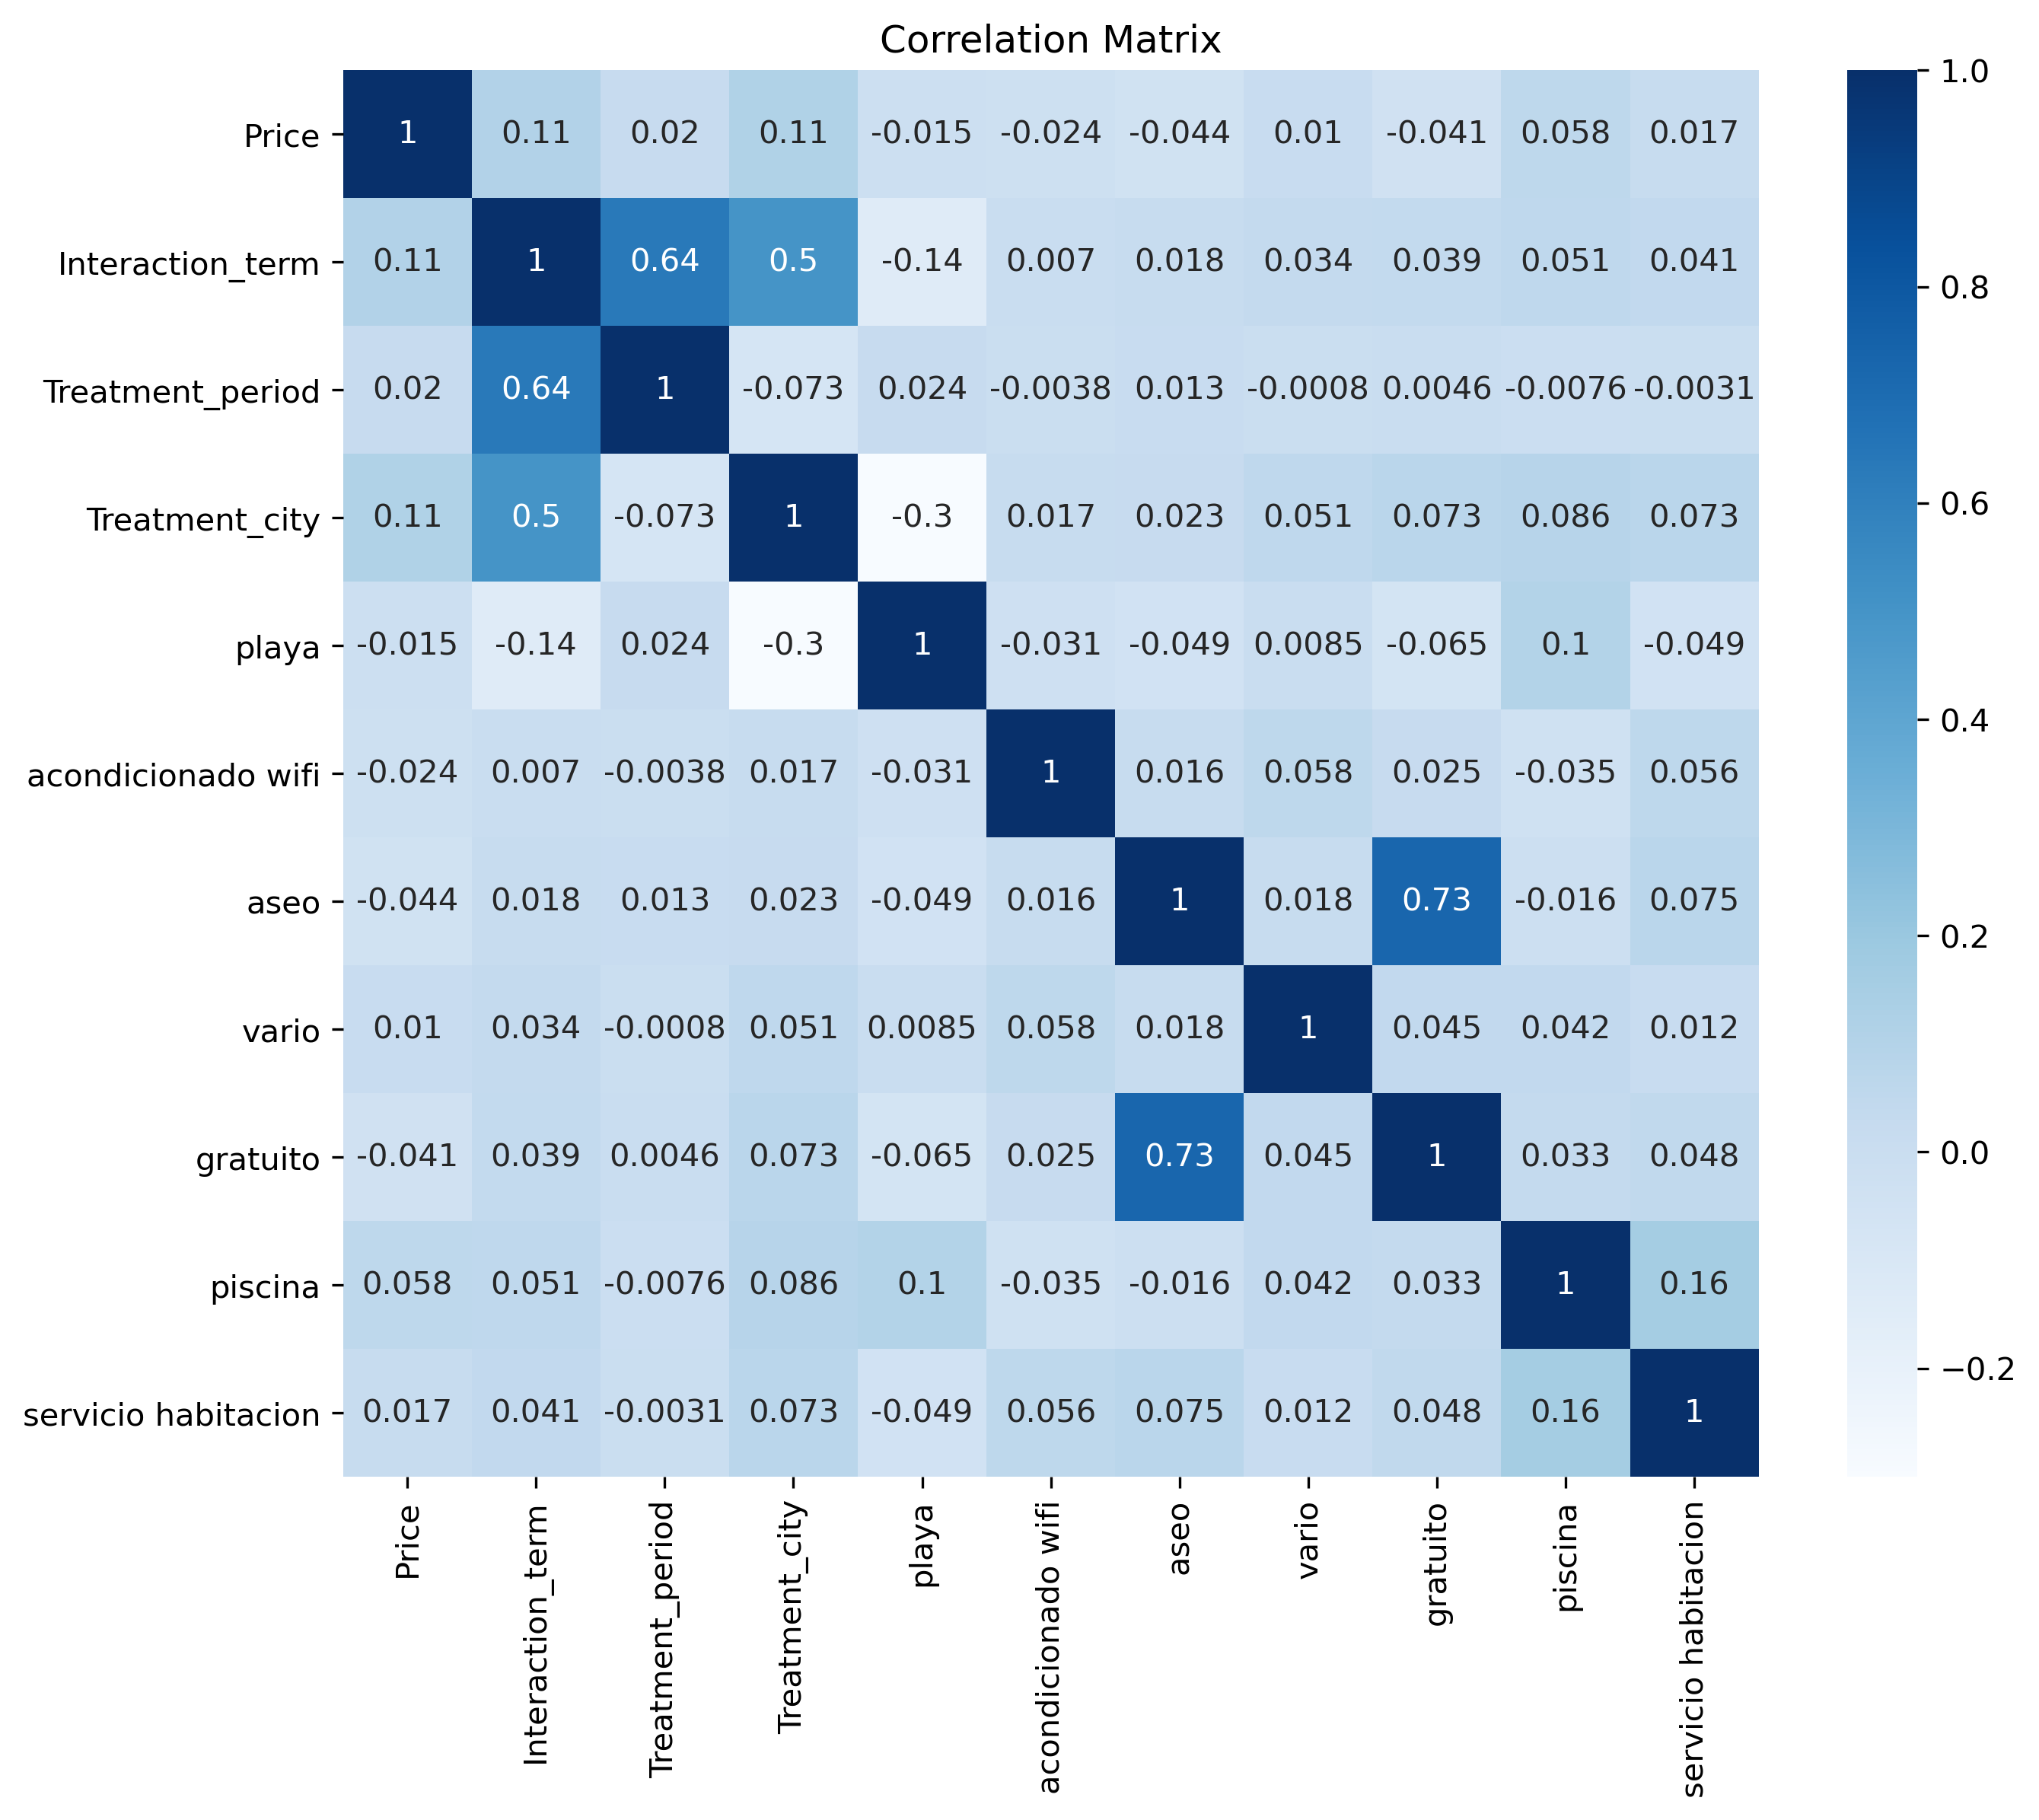

In [572]:
# Select columns for correlation matrix
# Replace 'Word1', 'Word2', etc., with the actual column names of word frequencies
# and any other columns you want to include
selected_columns = ['Price','Interaction_term', 'Treatment_period', 'Treatment_city', 'Treatment_city_and_treatment', 'playa', 'acondicionado wifi','aseo','vario','gratuito',"piscina","servicio habitacion"]
correlation_df = final_df[selected_columns]

# Compute the correlation matrix
corr_matrix = correlation_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

#### Word Cloud (General DTM)



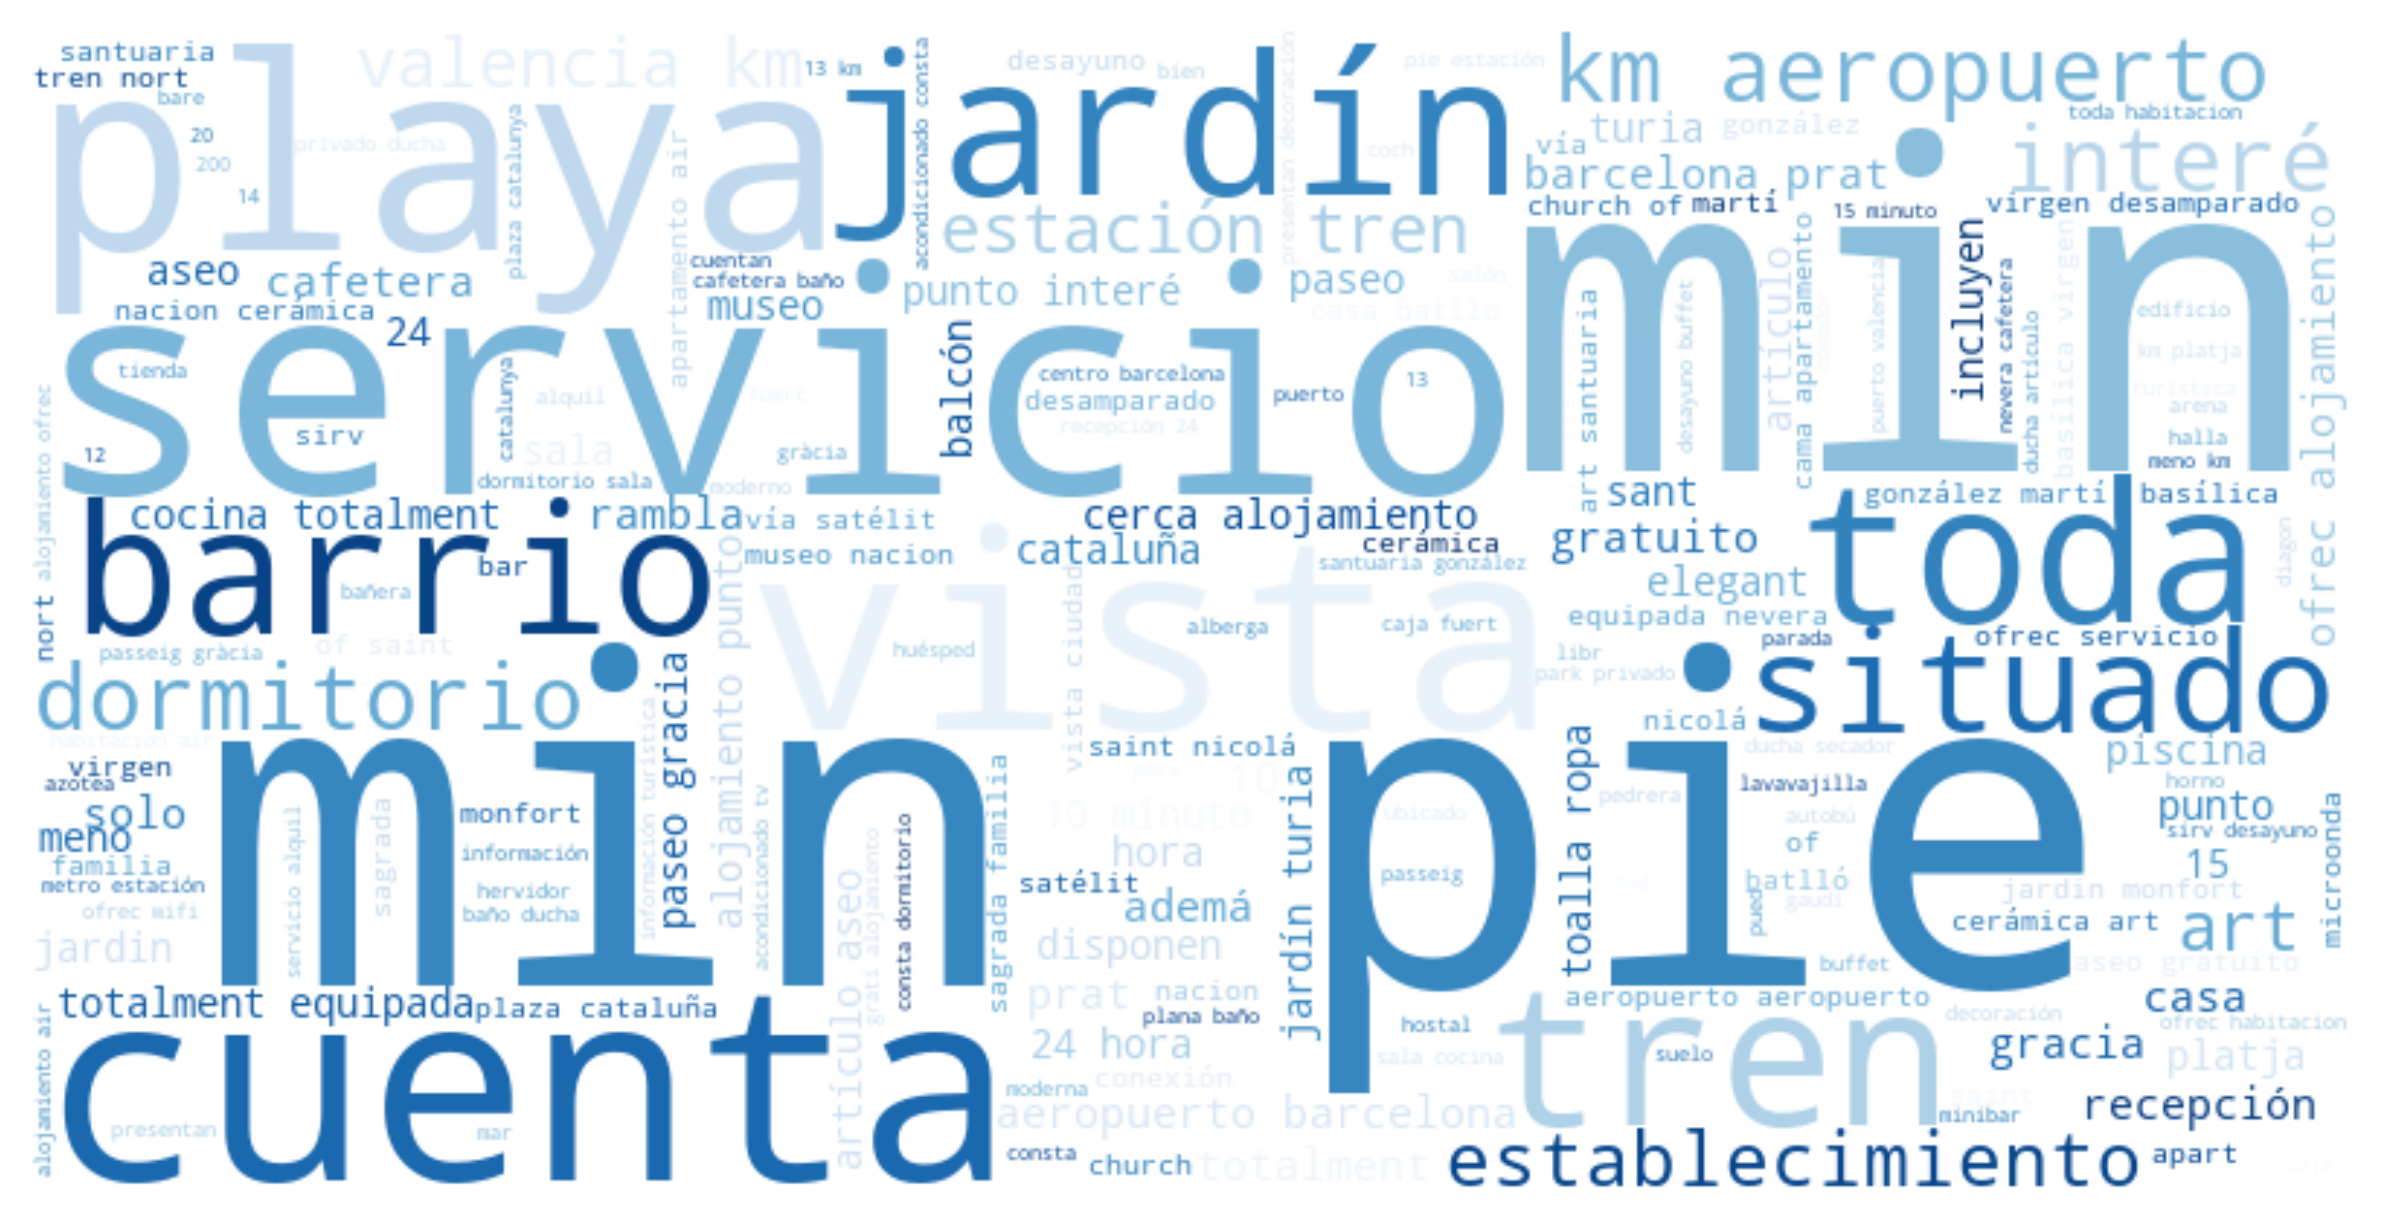

In [573]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a high-resolution word cloud object with relative scaling
wordcloud = WordCloud(
    background_color='white', 
    colormap='Blues', 
    width=800, 
    height=400,
    relative_scaling= 0  # Adjust the relative scaling value as desired
).generate_from_frequencies(dtm_df.sum())

# Plot the word cloud with a higher resolution
plt.figure(figsize=(10, 6), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### Creating Term Frequency (TF)-Inverse Document Frequency (IDF) and text_length features 

In [574]:
# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.30)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Convert TF-IDF to DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Reset index of the original DataFrame to avoid duplicate indices
df = df.reset_index(drop=True)

# Add length feature
tfidf_df['text_length'] = df['processed_text'].apply(len)

# Concatenate the TF-IDF features and length with your original DataFrame
final_df = pd.concat([df, tfidf_df], axis=1)

# Display the final DataFrame
display(final_df)


,Unnamed: 0,Hotels,Ratings,Price,Link,Stars,Descriptions,Treatment_period,Treatment_city,Treatment_city_and_treatment,Interaction_term,processed_text,10,10 minuto,100,100 metro,11,11 km,12,12 km,13,13 km,14,14 km,15,15 minuto,16,17,19,20,20 minuto,200,200 metro,24,24 hora,300,300 metro,400,500,500 metro,abierta,acceso,acondicionado consta,acondicionado tv,acondicionado wifi,ademá,ademá cafetera,aeropuerto aeropuerto,aeropuerto barcelona,air libr,alberga,alojamiento air,alojamiento ofrec,alojamiento punto,alojamiento wifi,alquil,alrededor,amplia,aparcamiento,apart,apartamento air,apartamento cerca,apartamento km,apartamento ofrec,arena,art,art ciencia,art santuaria,artículo,artículo aseo,aseo,aseo gratuito,autobú,azotea,balcón,bar,barcelona ofrec,barcelona prat,barceloneta,bare,bare restaurant,barrio,barrio gótico,basílica,basílica virgen,batlló,bañera,baño compartido,baño ducha,bicicleta,bidet,bien,bioparc,bioparc valencia,boquería,buffet,cada,cafetera,cafetera baño,cafetera hervidor,cafetería,caja,caja fuert,calefacción,cama apartamento,cama toalla,canal,casa,casa batlló,catalana,catalunya,cataluña,catedr,catedr barcelona,centro barcelona,centro valencia,cerca alojamiento,cerámica,cerámica art,church,church of,ciencia,ciudad art,coch,cocina nevera,cocina totalment,comedor,comerci,compartida,compartido,común,conexión,conexión wi,conexión wifi,consta,consta dormitorio,cuenta,cuentan,decoración,desamparado,desayuno,desayuno buffet,diagon,diseño,disponen,disponen air,distancia,dormitorio,dormitorio sala,ducha artículo,ducha secador,edificio,eixampl,elegant,encuentra barcelona,encuentra barrio,encuentra centro,encuentra valencia,encuentran,equipada nevera,equipado,escritorio,establecimiento,estación tren,familia,famosa,fi,fi gratuita,fogon,fuent,fuent mágica,fuert,gaudí,gimnasio,gonzález,gonzález martí,gracia,gran,grati alojamiento,grati apartamento,gratuita toda,gratuito,gratuito secador,gràcia,gótico,habitacion air,habitacion hotel,habitacion incluyen,habitación,halla,hervidor,histórico,hora,horno,hostal,huésped,incluy,incluyen,independient,información,información turística,instalacion,interé,ir,ir volver,jardin,jardin monfort,jardín,jardín turia,junto,km aeropuerto,km church,km estación,km jardín,km platja,km playa,lavadora,lavavajilla,libr,lugar,lugar interé,madera,malvarrosa,mar,martí,meno,meno km,mercado,mercado boquería,metro estación,metro passeig,metro plaza,microonda,mientra,min,min pie,minibar,moderna,moderno,monfort,monfort km,montjuïc,mostrador,mostrador información,museo,museo nacion,mágica,música,nacion,nacion cerámica,nevera cafetera,nevera lavavajilla,nicolá,nort,nort km,nou,numeroso,oceanográfico,of,of saint,ofrec alojamiento,ofrec habitacion,ofrec servicio,ofrec wifi,ofrecen,pago,pago ir,palacio,parada,park,park privado,parqu,paseo,paseo gracia,passeig,passeig gràcia,pedrera,person,pie estación,pie playa,pie plaza,piscina,piscina air,plana baño,plana cocina,platja,plato,playa,playa arena,playa malvarrosa,plaza catalunya,plaza cataluña,poca,poca distancia,prat,presentan,presentan decoración,privado ducha,privado secador,proporciona,pued,pueden,puerto,puerto valencia,punto,punto interé,queda,rambla,recepción,recepción 24,sagrada,sagrada familia,saint,saint nicolá,sala,sala cocina,salón,sant,santuaria,santuaria gonzález,satélit,servicio,servicio alquil,servicio habitacion,servicio traslado,sirv,sirv desayuno,situado,sofá,solo,solo minuto,suelo,suplemento,teatro,temporada,tienda,toalla ropa,toda,toda habitacion,totalment,totalment equipada,traslado,traslado pago,tren,tren nort,tren sant,turia,turia km,turística,tv vía,ubicado,unidad,uso,valencia km,valencia ofrec,vario,virgen,virgen desamparado,vista,vista ciudad,volver,volver aeropuerto,vía,vía satélit,wi,wi fi,zona comedor,text_length
0,0,Room Mate Gerard,"8,8",578,https://www.booking.com/hotel/es/room-mate-ger...,4,El Room Mate Gerard en Barcelona ofrece alojam...,0,1,Treatment_city_p1,0,room mate gerard barcelona ofrec alojamiento p...,0.000000,0.000000,0.000000

### Show top words

In [575]:
from nltk.corpus import stopwords

# Assuming 'Descriptions' is the column containing text descriptions
corpus = df['Descriptions']

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=stopwords.words("spanish"))
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

# Get feature names and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.toarray()

# Create a DataFrame to display the top words and their TF-IDF scores
tfidf_df = pd.DataFrame(tfidf_scores, columns=feature_names)

# Display the top words and their TF-IDF scores
top_words = tfidf_df.sum(axis=0).sort_values(ascending=False)
print(top_words)


km             348.778924
alojamiento    279.459162
valencia       242.032225
aeropuerto     211.083193
barcelona      201.014777
                  ...    
offers           1.940766
metres           1.883107
airport          1.640668
it               1.635433
screen           1.402476
Length: 1000, dtype: float64


### Sentiment Analysis

In [576]:
# Assuming 'Descriptions' is the column containing text descriptions
final_df['sentiment'] = final_df['Descriptions'].apply(lambda x: TextBlob(x).sentiment.polarity)
final_df

,Unnamed: 0,Hotels,Ratings,Price,Link,Stars,Descriptions,Treatment_period,Treatment_city,Treatment_city_and_treatment,Interaction_term,processed_text,10,10 minuto,100,100 metro,11,11 km,12,12 km,13,13 km,14,14 km,15,15 minuto,16,17,19,20,20 minuto,200,200 metro,24,24 hora,300,300 metro,400,500,500 metro,abierta,acceso,acondicionado consta,acondicionado tv,acondicionado wifi,ademá,ademá cafetera,aeropuerto aeropuerto,aeropuerto barcelona,air libr,alberga,alojamiento air,alojamiento ofrec,alojamiento punto,alojamiento wifi,alquil,alrededor,amplia,aparcamiento,apart,apartamento air,apartamento cerca,apartamento km,apartamento ofrec,arena,art,art ciencia,art santuaria,artículo,artículo aseo,aseo,aseo gratuito,autobú,azotea,balcón,bar,barcelona ofrec,barcelona prat,barceloneta,bare,bare restaurant,barrio,barrio gótico,basílica,basílica virgen,batlló,bañera,baño compartido,baño ducha,bicicleta,bidet,bien,bioparc,bioparc valencia,boquería,buffet,cada,cafetera,cafetera baño,cafetera hervidor,cafetería,caja,caja fuert,calefacción,cama apartamento,cama toalla,canal,casa,casa batlló,catalana,catalunya,cataluña,catedr,catedr barcelona,centro barcelona,centro valencia,cerca alojamiento,cerámica,cerámica art,church,church of,ciencia,ciudad art,coch,cocina nevera,cocina totalment,comedor,comerci,compartida,compartido,común,conexión,conexión wi,conexión wifi,consta,consta dormitorio,cuenta,cuentan,decoración,desamparado,desayuno,desayuno buffet,diagon,diseño,disponen,disponen air,distancia,dormitorio,dormitorio sala,ducha artículo,ducha secador,edificio,eixampl,elegant,encuentra barcelona,encuentra barrio,encuentra centro,encuentra valencia,encuentran,equipada nevera,equipado,escritorio,establecimiento,estación tren,familia,famosa,fi,fi gratuita,fogon,fuent,fuent mágica,fuert,gaudí,gimnasio,gonzález,gonzález martí,gracia,gran,grati alojamiento,grati apartamento,gratuita toda,gratuito,gratuito secador,gràcia,gótico,habitacion air,habitacion hotel,habitacion incluyen,habitación,halla,hervidor,histórico,hora,horno,hostal,huésped,incluy,incluyen,independient,información,información turística,instalacion,interé,ir,ir volver,jardin,jardin monfort,jardín,jardín turia,junto,km aeropuerto,km church,km estación,km jardín,km platja,km playa,lavadora,lavavajilla,libr,lugar,lugar interé,madera,malvarrosa,mar,martí,meno,meno km,mercado,mercado boquería,metro estación,metro passeig,metro plaza,microonda,mientra,min,min pie,minibar,moderna,moderno,monfort,monfort km,montjuïc,mostrador,mostrador información,museo,museo nacion,mágica,música,nacion,nacion cerámica,nevera cafetera,nevera lavavajilla,nicolá,nort,nort km,nou,numeroso,oceanográfico,of,of saint,ofrec alojamiento,ofrec habitacion,ofrec servicio,ofrec wifi,ofrecen,pago,pago ir,palacio,parada,park,park privado,parqu,paseo,paseo gracia,passeig,passeig gràcia,pedrera,person,pie estación,pie playa,pie plaza,piscina,piscina air,plana baño,plana cocina,platja,plato,playa,playa arena,playa malvarrosa,plaza catalunya,plaza cataluña,poca,poca distancia,prat,presentan,presentan decoración,privado ducha,privado secador,proporciona,pued,pueden,puerto,puerto valencia,punto,punto interé,queda,rambla,recepción,recepción 24,sagrada,sagrada familia,saint,saint nicolá,sala,sala cocina,salón,sant,santuaria,santuaria gonzález,satélit,servicio,servicio alquil,servicio habitacion,servicio traslado,sirv,sirv desayuno,situado,sofá,solo,solo minuto,suelo,suplemento,teatro,temporada,tienda,toalla ropa,toda,toda habitacion,totalment,totalment equipada,traslado,traslado pago,tren,tren nort,tren sant,turia,turia km,turística,tv vía,ubicado,unidad,uso,valencia km,valencia ofrec,vario,virgen,virgen desamparado,vista,vista ciudad,volver,volver aeropuerto,vía,vía satélit,wi,wi fi,zona comedor,text_length,sentiment
0,0,Room Mate Gerard,"8,8",578,https://www.booking.com/hotel/es/room-mate-ger...,4,El Room Mate Gerard en Barcelona ofrece alojam...,0,1,Treatment_city_p1,0,room mate gerard barcelona ofrec alojamiento p...,0.000000,0.00000

### Feature Selection

In [577]:
final_df.columns.tolist()

['Unnamed: 0',
 'Hotels',
 'Ratings',
 'Price',
 'Link',
 'Stars',
 'Descriptions',
 'Treatment_period',
 'Treatment_city',
 'Treatment_city_and_treatment',
 'Interaction_term',
 'processed_text',
 '10',
 '10 minuto',
 '100',
 '100 metro',
 '11',
 '11 km',
 '12',
 '12 km',
 '13',
 '13 km',
 '14',
 '14 km',
 '15',
 '15 minuto',
 '16',
 '17',
 '19',
 '20',
 '20 minuto',
 '200',
 '200 metro',
 '24',
 '24 hora',
 '300',
 '300 metro',
 '400',
 '500',
 '500 metro',
 'abierta',
 'acceso',
 'acondicionado consta',
 'acondicionado tv',
 'acondicionado wifi',
 'ademá',
 'ademá cafetera',
 'aeropuerto aeropuerto',
 'aeropuerto barcelona',
 'air libr',
 'alberga',
 'alojamiento air',
 'alojamiento ofrec',
 'alojamiento punto',
 'alojamiento wifi',
 'alquil',
 'alrededor',
 'amplia',
 'aparcamiento',
 'apart',
 'apartamento air',
 'apartamento cerca',
 'apartamento km',
 'apartamento ofrec',
 'arena',
 'art',
 'art ciencia',
 'art santuaria',
 'artículo',
 'artículo aseo',
 'aseo',
 'aseo gratuito'

In [578]:
final_df['luxury'] = final_df.apply(lambda row: 1 if any(row[['elegant', 'moderna', 'moderno', 'privado ducha', 'piscina']] != 0) else 0, axis=1)

In [579]:
final_df['amenities'] = final_df.apply(lambda row: 1 if any(row[['conexión wifi', 'wi fi', 'park privado', 'aparcamiento', 'piscina']] != 0) else 0, axis=1)

### Ideas for NLP:
- Including Keyword presence (words related to Sonar Festival)
- Word Embeddings (Optional)


 *4) b) Run a 4th regression and add it to your table. This should add your controls to your 3rd regression. Interpret the coefficient on the controls and the change you see on your treatment variable. (2 points)*

### Final Regression

### Adding NLP Features

In [580]:
# Regression with both "treatment period" and "treatment city" dummies and their interaction
final_df['Interaction_term'] = final_df['Treatment_period'] * final_df['Treatment_city']
X4 = sm.add_constant(final_df[['Treatment_period', 'Treatment_city', 'Interaction_term', 'luxury','amenities','Stars']])
model4 = sm.OLS(final_df['Price'], X4)
results4 = model4.fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     29.57
Date:                Sat, 03 Feb 2024   Prob (F-statistic):           1.46e-34
Time:                        19:58:07   Log-Likelihood:                -22418.
No. Observations:                2902   AIC:                         4.485e+04
Df Residuals:                    2895   BIC:                         4.489e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              261.5430     31.825  

### Interpretation of regression 4

In our fourth and final regression model, we incorporated set of terms from the document term matrix that are correlated with hotel pricing. This analysis is enriched by the inclusion of both city and time period dummy variables, which serve to adjust for consistent effects over time, as well as an interaction term to understand the combined influences. Essentially, this regression points out how certain descriptive words in hotel listings are associated with pricing - whether they contribute to a price increase or decrease.

We observe that the interaction term remains significant. This suggests that the event happening in barcelona during that time period does have a positive influence on the hotel pricing. 

Furthermore, the analysis reveals some other intriguing findings:

+ The term "estrella" appears to have a significant impact, being associated with an increase in hotel pricing by approximately 1400.6483 euros. This is intuitive, as hotel with stars are strongly correlated to the hotel ratings, themselves strongly correlated to the price.

+ Similarly, the presence of "vario" in the hotel description correlates with a price increase of about 1268.2689 euros.

+ On the other hand, the word "gratuito" seems to correlate with a price reduction of 603.7632  euros.This could indicate that hotels highlighting free services or amenities might be positioned in a more economical pricing segment.

+ Interestingly, the word "servicio habitacion" (room service) is linked with an increase of 877.5070 euros in hotel pricing. This suggest that hotels with room service tend to be more expensive on average.



### Assembling the 4 regressions

In [581]:
# REGRESSION1
# Regression with only "treatment period" dummy
X1 = sm.add_constant(df['Treatment_city'])
model1 = sm.OLS(df['Price'], X1)
results1 = model1.fit()

# REGRESSION2
# Regression with only "treatment period" dummy
X2 = sm.add_constant(df['Treatment_period'])
model2 = sm.OLS(df['Price'], X2)
results2 = model2.fit()

#REGRESSION3
# Regression with both "treatment period" and "treatment city" dummies and their interaction
df['Interaction_term'] = df['Treatment_period'] * df['Treatment_city']
X3 = sm.add_constant(df[['Treatment_period', 'Treatment_city', 'Interaction_term']])
model3 = sm.OLS(df['Price'], X3)
results3 = model3.fit()

# REGRESSION4
# Creating the interaction term
final_df['Interaction_term'] = final_df['Treatment_period'] * final_df['Treatment_city']
X4 = sm.add_constant(final_df[['Treatment_period', 'Treatment_city', 'Interaction_term', 'luxury','amenities','Stars']])
model4 = sm.OLS(final_df['Price'], X4)
results4 = model4.fit()

# Create Stargazer object
stargazer = Stargazer([results1, results2, results3, results4])

# Optionally, customize the Stargazer object
stargazer.title("Regression Results")
stargazer.custom_columns(['Model 1', 'Model 2', 'Model 3', 'Model 4'], [1, 1, 1, 1])
stargazer.show_model_numbers(False)
# You can add more customization as needed

# Render the LaTeX table
#print(stargazer.render_latex())


# Create a Stargazer object
stargazer = Stargazer([results1, results2, results3, results4])

# Customize the Stargazer object
stargazer.title("Regression Results")
stargazer.custom_columns(['Model 1', 'Model 2', 'Model 3', 'Model 4'], [1, 1, 1, 1])
stargazer.show_model_numbers(False)

# Convert to HTML and display
html_table = stargazer.render_html()
display(HTML(html_table))


## Robustness Checks

In order to assess the robustness of our results, we decided to compute the average price in both cities and for multiple time periods (here days), before the event, during and after the event. The presence of an increase in the hotel prices in barcelona during the event would confirm the existence of a causal link between the sonar festival and the hotel prices increase. 

In [582]:
mean_price=[]
df = pd.read_csv("robustness_check/Valencia_Data_21_22.csv")
df['Price'] = df['Price'].str.replace('€', '').astype(int)
mean_price = df['Price'].mean()
print(mean_price)

407.0769230769231


In [583]:
# Barcelona
barcelona_dict = {
    '04 June 2024': '144.07692307692307',
    '05 June 2024': '145.73076923076923',
    '06 June 2024': '138.6153846153846',
    '07 June 2024': '173.36',
    '08 June 2024': '175.24',
    '09 June 2024': '142.30769230769232',
    '10 June 2024': '144.80769230769232',
    '11 June 2024': '194.5',
    '12 June 2024': '147.1818181818182',
    '13 June 2024': '183.03846153846155',
    '14 June 2024': '197.64',
    '15 June 2024': '197.8',
    '16 June 2024': '151.5',
    '17 June 2024': '150.53846153846155',
    '18 June 2024': '160.5',
    '19 June 2024': '153.47171945701356',
    '20 June 2024': '184.5228951255539',
    '21 June 2024': '251.24',
}

bcn_daily = pd.DataFrame.from_dict(barcelona_dict, orient='index', columns=['Price']).reset_index()
bcn_daily.columns = ['Date', 'Price']
bcn_daily['Price'] = bcn_daily['Price'].astype(float)
bcn_daily['Date'] = pd.to_datetime(bcn_daily['Date'])


In [584]:
# Barcelona
valencia_dict = {
    '04 June 2024': '106.07692307692308',
    '05 June 2024': '107.0',
    '06 June 2024': '103.76',
    '07 June 2024': '143.96',
    '08 June 2024': '152.52',
    '09 June 2024': '91.76923076923077',
    '10 June 2024': '106.88461538461539',
    '11 June 2024': '110.653846153846168',
    '12 June 2024': '108.57692307692308',
    '13 June 2024': '102.48',
    '14 June 2024': '119.24',
    '15 June 2024': '149.32',
    '16 June 2024': '94.53846153846153',
    '17 June 2024': '104.38461538461539',
    '18 June 2024': '110.61538461538461',
    '19 June 2024': '109.11538461538461',
    '20 June 2024': '100.12',
    '21 June 2024': '131.96',
}

vlc_daily = pd.DataFrame.from_dict(valencia_dict, orient='index', columns=['Price']).reset_index()
vlc_daily.columns = ['Date', 'Price']
vlc_daily['Price'] = vlc_daily['Price'].astype(float)
vlc_daily['Date'] = pd.to_datetime(vlc_daily['Date'])


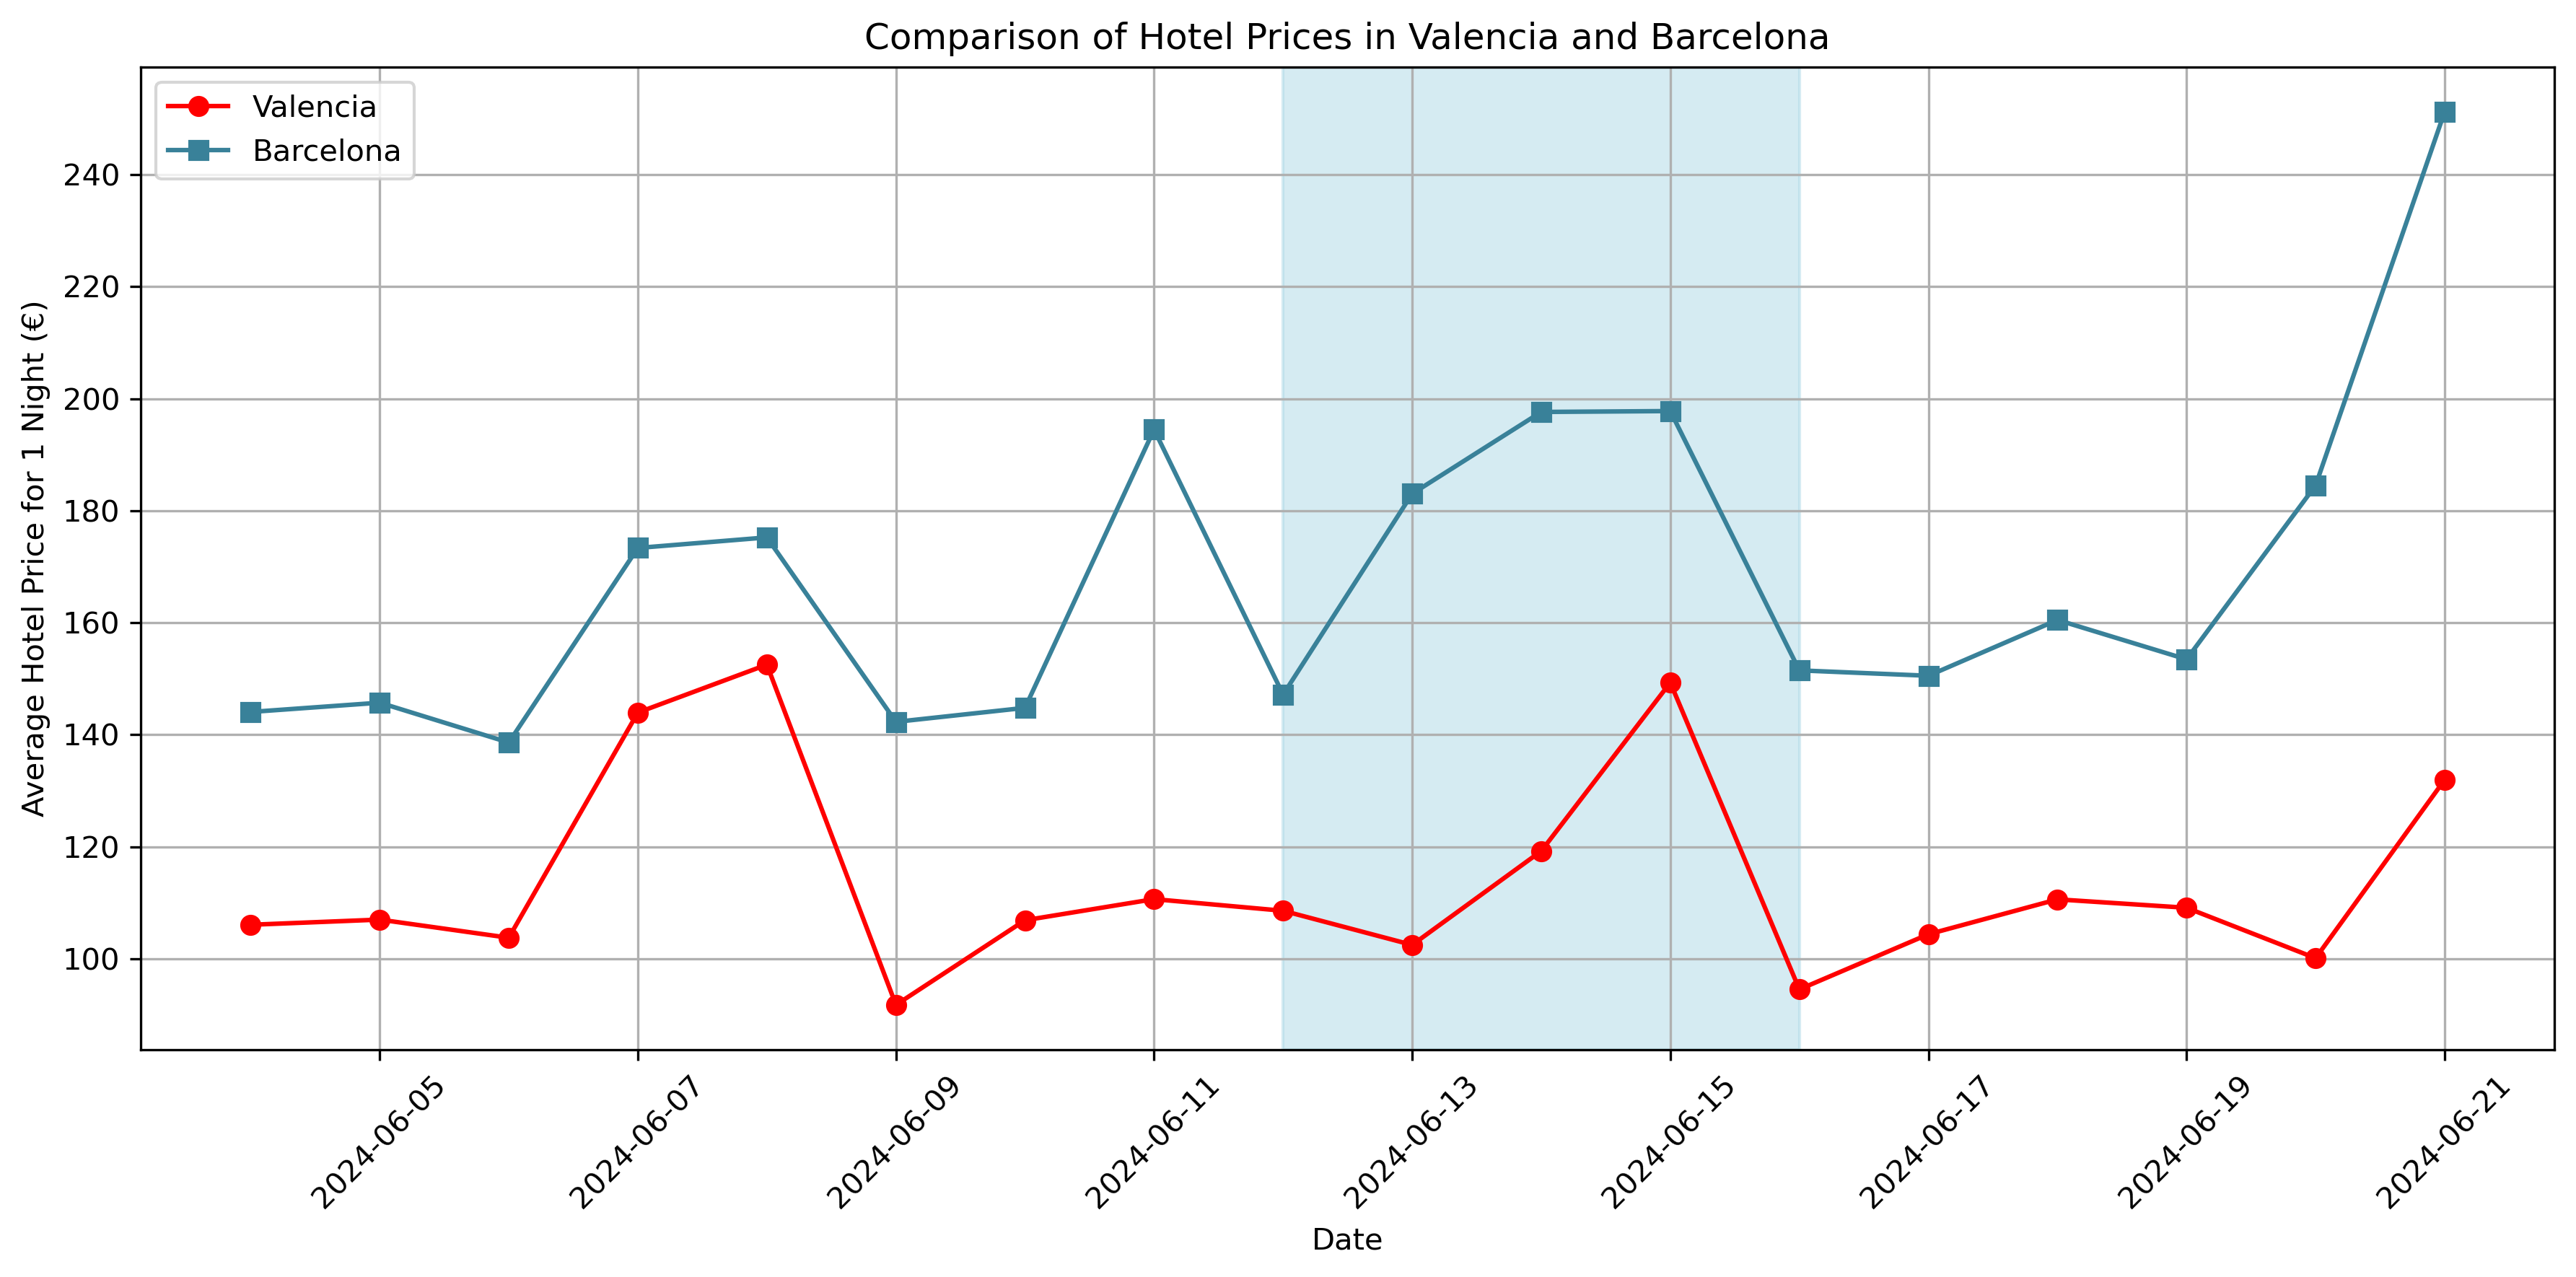

In [585]:
# Plotting the mean hotel prices for Valencia and Barcelona
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(vlc_daily['Date'], vlc_daily['Price'], label='Valencia', marker='o', linestyle='-', color='red')
plt.plot(bcn_daily['Date'], bcn_daily['Price'], label='Barcelona', marker='s', linestyle='-', color=color)

# Highlighting the interval
start_highlight = pd.to_datetime('2024-06-12')
end_highlight = pd.to_datetime('2024-06-16')
plt.axvspan(start_highlight, end_highlight, color='lightblue', alpha=0.5)

plt.title('Comparison of Hotel Prices in Valencia and Barcelona')
plt.xlabel('Date')
plt.ylabel('Average Hotel Price for 1 Night (€)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()

### *8. Imagine that you instead run the regression with hotel fixed effects (no need to run). Explain why the treatment effect will change and why your regression with controls should be closer to this regression. (2 points)*

Running a regression with hotel fixed effects means that we are controlling for the unobserved heterogeneity that are unique to each hotel and are constant across time, this reduces omitted variable bias. 

The analysis focuses on the variation in the treatment effect within hotels over time. This allows us to have a more precise estimate. The magnitude of the treatment effect may change because the fixed effects model is capturing and accounting for additional sources of variation, we could split the treatment effect from other cofounding factors. 

Our regression with controls should be closer to this regression because if this happens this suggest that the control variables capture some of the unobserved heterogeneity that the fixed effects model is addressing. The fixed effects model is more robust in dealing with unobserved heterogeneity.